┌─────────┬─────────┬─────────┬─────────┬─────────┬───────────┬─────────┬─────────┬─────────┬─────────┬──────────┬─────────┬─────────┬─────────┬─────────┐
│      τb │      τw │       r │      tr │   diffv │ diffasset │ diffgbc │     Rss │     Wss │    Trss │ Frac_bss │     Vss │     Ass │     Css │   value │
│ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │   Float64 │ Float64 │ Float64 │ Float64 │ Float64 │  Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
└─────────┴─────────┴─────────┴─────────┴─────────┴───────────┴─────────┴─────────┴─────────┴─────────┴──────────┴─────────┴─────────┴─────────┴─────────┘


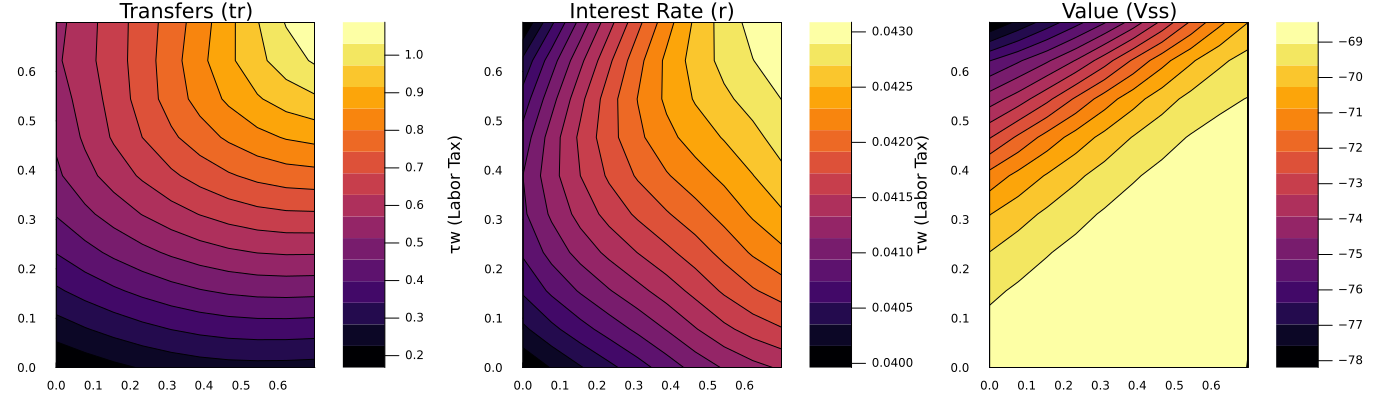

In [1]:
using CSV, DataFrames, Statistics, Plots, PrettyTables

# Set path and load data
path = "/Users/apb/Dropbox/optimal_business_taxation/noncompliance/Approximation Code/"
cd(path)
df = CSV.read(path*"grid_results_with_values.csv", DataFrame)

# Identify rows with missing critical values
nan_rows = filter(row -> any(ismissing, [row.r, row.tr, row.value]), df)
pretty_table(nan_rows)

# Sort tax values
τb_vals = sort(unique(df.τb))
τw_vals = sort(unique(df.τw))

# Initialize Z matrices
Z_tr  = fill(NaN, length(τw_vals), length(τb_vals))
Z_r   = fill(NaN, length(τw_vals), length(τb_vals))
Z_Vss = fill(NaN, length(τw_vals), length(τb_vals))

# Populate matrices
for (i, τw) in enumerate(τw_vals)
    for (j, τb) in enumerate(τb_vals)
        row = filter(r -> r.τb ≈ τb && r.τw ≈ τw, df)
        if nrow(row) == 1
            Z_tr[i, j]  = row.tr[1]
            Z_r[i, j]   = row.r[1]
            Z_Vss[i, j] = row.Vss[1]
        end
    end
end

# Plot 3 side-by-side contour plots
plot(
    contour(τb_vals, τw_vals, Z_tr;
        xlabel = "τb (Business Tax)",
        ylabel = "τw (Labor Tax)",
        title = "Transfers (tr)",
        fill = true,
        cbar = true),
    
    contour(τb_vals, τw_vals, Z_r;
        xlabel = "τb (Business Tax)",
        ylabel = "τw (Labor Tax)",
        title = "Interest Rate (r)",
        fill = true,
        cbar = true),

    contour(τb_vals, τw_vals, Z_Vss;
        xlabel = "τb (Business Tax)",
        ylabel = "τw (Labor Tax)",
        title = "Value (Vss)",
        fill = true,
        cbar = true),

    layout = (1, 3),
    size = (1400, 400)
)


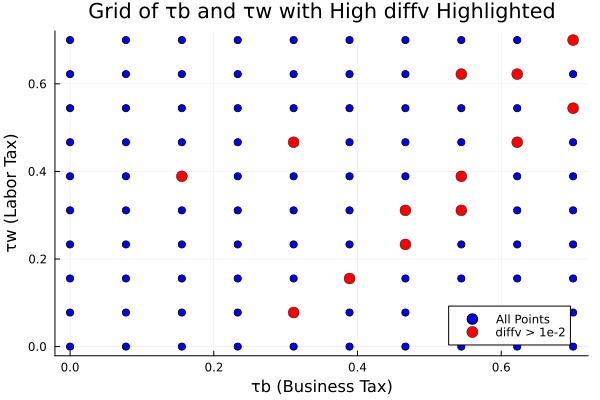

In [2]:
# Filter valid (non-NaN) rows
df_all = filter(row -> !isnan(row.diffv), df)

# Separate those with large diffv > 1e-2
df_bad = filter(row -> row.diffv > 1e-2, df_all)

# Plot all points in blue
scatter(
    df_all.τb, df_all.τw,
    xlabel = "τb (Business Tax)",
    ylabel = "τw (Labor Tax)",
    title = "Grid of τb and τw with High diffv Highlighted",
    label = "All Points",
    color = :blue,
    markersize = 4,
    legend = :bottomright
)

# Overlay bad points in red
scatter!(
    df_bad.τb, df_bad.τw,
    label = "diffv > 1e-2",
    color = :red,
    markersize = 6,
    markerstrokewidth = 0.5
)


In [3]:
# Display using PrettyTables
pretty_table(df_bad[:, [:τb, :τw, :diffv]]; header=["τb", "τw", "diffv"])


┌──────────┬───────────┬───────────┐
│       τb │        τw │     diffv │
├──────────┼───────────┼───────────┤
│ 0.311111 │ 0.0777778 │  0.253143 │
│ 0.388889 │  0.155556 │ 0.0229116 │
│ 0.466667 │  0.233333 │ 0.0887088 │
│ 0.466667 │  0.311111 │ 0.0636702 │
│ 0.544444 │  0.311111 │ 0.0839325 │
│ 0.155556 │  0.388889 │ 0.0220546 │
│ 0.544444 │  0.388889 │ 0.0217038 │
│ 0.311111 │  0.466667 │ 0.0433642 │
│ 0.622222 │  0.466667 │   0.10074 │
│      0.7 │  0.544444 │ 0.0684441 │
│ 0.544444 │  0.622222 │ 0.0778548 │
│ 0.622222 │  0.622222 │ 0.0213762 │
│      0.7 │       0.7 │ 0.0244497 │
└──────────┴───────────┴───────────┘


Closest τb to 0.2 is 0.23333333333333334 (index 4)
Closest τw to 0.4 is 0.3888888888888889 (index 6)


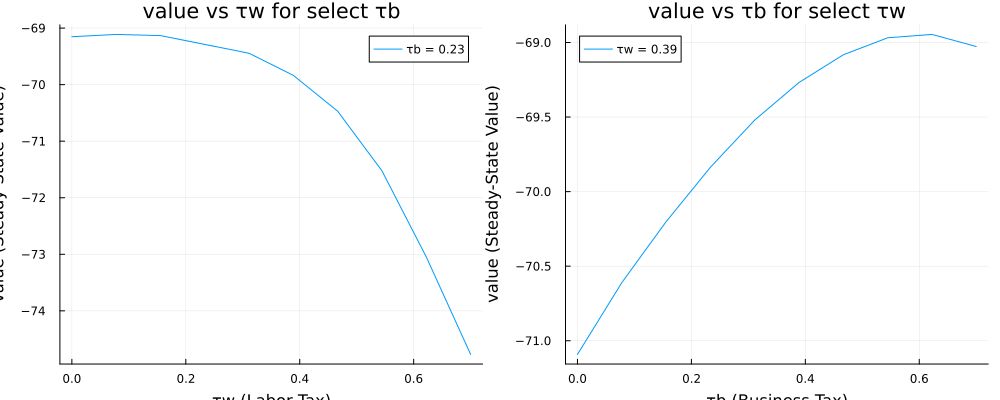

In [11]:
using Plots

col = :value

# === First subplot: value vs τw for select τb ===
τb_vals = unique(df.τb)
target = 0.2
# Compute the absolute difference and find the index of the minimum
idx = argmin(abs.(τb_vals .- target))
# Extract the closest value
closest_τb = τb_vals[idx]
println("Closest τb to $target is $closest_τb (index $idx)")




#select_τb = [minimum(τb_vals), τb_vals[idx],maximum(τb_vals)]  # or manually: [0.1, 0.3]
select_τb = [τb_vals[idx]]

p1 = plot()
for τb in select_τb
    df_τb = filter(row -> row.τb == τb && !isnan(row[col]), df)
    plot!(p1, df_τb.τw, df_τb[!, col], label = "τb = $(round(τb,digits=2))")
end
xlabel!(p1, "τw (Labor Tax)")
ylabel!(p1, "$col (Steady-State Value)")
title!(p1, "$col vs τw for select τb")

# === Second subplot: value vs τb for select τw ===
target = 0.4

# Compute the absolute difference and find the index of the minimum
idx = argmin(abs.(τw_vals .- target))
# Extract the closest value
closest_τw = τw_vals[idx]
println("Closest τw to $target is $closest_τw (index $idx)")
select_τw = [minimum(τw_vals), τw_vals[idx], maximum(τw_vals)]  # or manually: [0.1, 0.3]
select_τw = [τw_vals[idx]]

p2 = plot()
for τw in select_τw
    df_τw = filter(row -> row.τw == τw && !isnan(row[col]), df)
    plot!(p2, df_τw.τb, df_τw[!, col], label = "τw = $(round(τw,digits=2))")
end
xlabel!(p2, "τb (Business Tax)")
ylabel!(p2, "$col (Steady-State Value)")
title!(p2, "$col vs τb for select τw")

# === Combine side by side ===
plot(p1, p2, layout = (1, 2), size = (1000, 400))


In [12]:

# Find the row with the highest objective value
# Drop rows with missing values in :value
# Filter out rows where :value is NaN
df_clean = filter(:value => x -> !isnan(x), df)


best_row = df_clean[argmax(df_clean.value), :]

# Print the optimal tax rates and the associated value
println("Optimal τb (Capital Tax): ", best_row.τb)
println("Optimal τw (Labor Tax): ", best_row.τw)
println("Maximum Objective Value ss: ", best_row.Vss)
println("Maximum Objective Value: ", best_row.value)

# Optional: return the entire row
best_row


Optimal τb (Capital Tax): 0.6222222222222222
Optimal τw (Labor Tax): 0.3888888888888889
Maximum Objective Value ss: -68.76376096208469
Maximum Objective Value: -68.94595252789222


Row,τb,τw,r,tr,diffv,diffasset,diffgbc,Rss,Wss,Trss,Frac_bss,Vss,Ass,Css,value
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
55,0.622222,0.388889,0.0424962,0.773091,9.46852e-6,4.61782e-7,-2.68426e-7,1.0425,1.14059,0.773091,0.0965207,-68.7638,13.5909,1.79594,-68.946


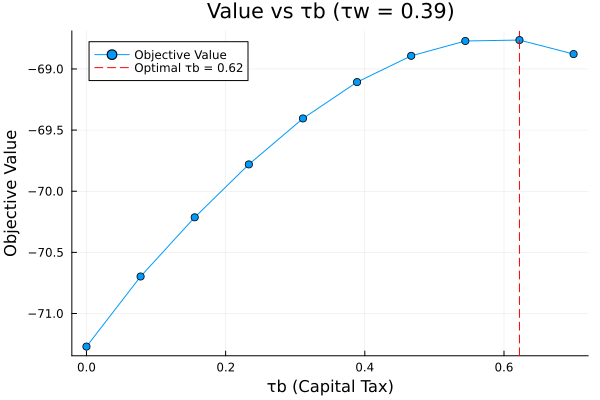

In [13]:

function plot_value_vs_taub(df, tauw_fixed::Float64)
    # Load and clean data
    df = filter(:value => x -> !isnan(x), df)

    # Filter rows where τw ≈ tauw_fixed
    df_sub = filter(row -> isapprox(row.τw, tauw_fixed; atol=1e-5), df)
    sort!(df_sub, :τb)

    # Find τb with maximum value
    idx_max = argmax(df_sub.Vss)
    best_taub = df_sub[idx_max, :τb]
    best_val = df_sub[idx_max, :value]

    # Plot value vs τb and vertical line
    plot(df_sub.τb, df_sub.Vss,
         marker = :circle, label = "Objective Value",
         xlabel = "τb (Capital Tax)", ylabel = "Objective Value",
         title = "Value vs τb (τw = $(round(tauw_fixed,digits=2)))", grid = true)
    vline!([best_taub], linestyle = :dash, color = :red, label = "Optimal τb = $(round(best_taub, digits=2))")
end

# Example usage
plot_value_vs_taub(df, best_row.τw)


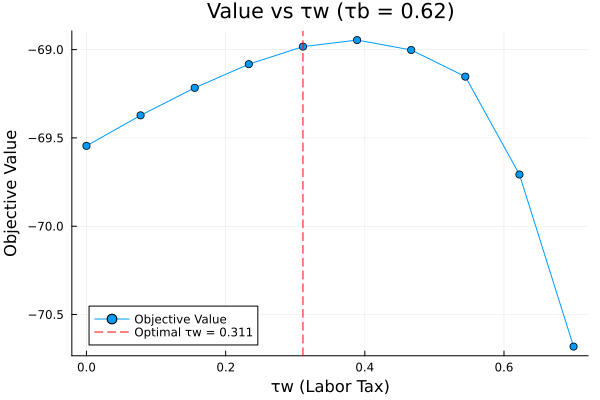

In [14]:

function plot_value_vs_tauw(df, taub_fixed::Float64)
    # Load and clean data
    df = filter(:value => x -> !isnan(x), df)

    # Filter rows where τb ≈ taub_fixed
    df_sub = filter(row -> isapprox(row.τb, taub_fixed; atol=1e-5), df)
    sort!(df_sub, :τw)

    # Find τw with maximum value
    idx_max = argmax(df_sub.Vss)
    best_tauw = df_sub[idx_max, :τw]
    best_val = df_sub[idx_max, :value]

    # Plot value vs τw and vertical line
    plot(df_sub.τw, df_sub.value,
         marker = :circle, label = "Objective Value",
         xlabel = "τw (Labor Tax)", ylabel = "Objective Value",
         title = "Value vs τw (τb = $(round(taub_fixed,digits=2)))", grid = true)
    vline!([best_tauw], linestyle = :dash, color = :red, label = "Optimal τw = $(round(best_tauw, digits=3))")
end

# Example usage
plot_value_vs_tauw(df, best_row.τb)
